##Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Project/1. Forecast/household_power_consumption.csv")

##Data Preprocessing

In [ ]:
df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"])
df = df.set_index("timestamp")
df = df.sort_index()

/tmp/ipython-input-2797048051.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"])


In [ ]:
numeric_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3"
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# ---- Hourly Aggregation (mean per hour) ----
df_hourly = df["Global_active_power"].resample("H").mean()

# ---- Handle missing hours ----
df_hourly = df_hourly.interpolate()

print("Hourly series shape:", df_hourly.shape)

Hourly series shape: (17477,)


/tmp/ipython-input-1775646764.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df["Global_active_power"].resample("H").mean()


In [ ]:
train_size = int(len(df_hourly) * 0.8)
train = df_hourly.iloc[:train_size]
test  = df_hourly.iloc[train_size:]

print("Train points:", len(train))
print("Test points:", len(test))

Train points: 13981
Test points: 3496


##SARIMA Model Hyperparameter Tuning

In [ ]:
def evaluate_forecast(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = (abs((y_true - y_pred) / y_true).mean()) * 100
    smape = (2 * np.mean(np.abs(y_pred - y_true) /
             (np.abs(y_true) + np.abs(y_pred)))) * 100

    return mae, rmse, mape, smape

In [ ]:
m = 24

In [ ]:
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]

P_values = [0, 1]
D_values = [1]
Q_values = [0, 1]

In [ ]:
param_grid = list(itertools.product(
    p_values, d_values, q_values,
    P_values, D_values, Q_values
))

print(f"Trying {len(param_grid)} SARIMA combinations...")

Trying 72 SARIMA combinations...


## Model Training and Evaluation

In [ ]:
sarima_results = []
sarima_predictions_store = {}

for (p,d,q,P,D,Q) in param_grid:
    try:
        model = SARIMAX(
            train,
            order=(p,d,q),
            seasonal_order=(P,D,Q,m),
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        fit = model.fit(disp=False)

        preds = fit.forecast(len(test))
        preds = pd.Series(preds, index=test.index)

        mae, rmse, mape, smape = evaluate_forecast(test, preds)

        sarima_results.append([
            f"SARIMA({p},{d},{q})x({P},{D},{Q})[{m}]",
            p,d,q,P,D,Q, mae, rmse, mape, smape
        ])

        sarima_predictions_store[(p,d,q,P,D,Q)] = preds

        print(f"Done -> SARIMA({p},{d},{q})x({P},{D},{Q})[{m}]  RMSE={rmse:.4f}")

    except Exception as e:
        print(f"Skipped -> SARIMA({p},{d},{q})x({P},{D},{Q})[{m}]  Error: {e}")
        continue


sarima_df = pd.DataFrame(
    sarima_results,
    columns=[
        "Model","p","d","q","P","D","Q",
        "MAE","RMSE","MAPE","sMAPE"
    ]
)

Done -> SARIMA(0,0,0)x(0,1,0)[24]  RMSE=1.0060
Done -> SARIMA(0,0,0)x(0,1,1)[24]  RMSE=0.8370
Done -> SARIMA(0,0,0)x(1,1,0)[24]  RMSE=0.9833


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Done -> SARIMA(0,0,0)x(1,1,1)[24]  RMSE=0.8328
Done -> SARIMA(0,0,1)x(0,1,0)[24]  RMSE=1.0049
Done -> SARIMA(0,0,1)x(0,1,1)[24]  RMSE=0.8306
Done -> SARIMA(0,0,1)x(1,1,0)[24]  RMSE=0.9849
Done -> SARIMA(0,0,1)x(1,1,1)[24]  RMSE=0.8281
Done -> SARIMA(0,0,2)x(0,1,0)[24]  RMSE=1.0042
Done -> SARIMA(0,0,2)x(0,1,1)[24]  RMSE=0.8278
Done -> SARIMA(0,0,2)x(1,1,0)[24]  RMSE=0.9869
Done -> SARIMA(0,0,2)x(1,1,1)[24]  RMSE=0.8259
Done -> SARIMA(0,1,0)x(0,1,0)[24]  RMSE=2.3162
Done -> SARIMA(0,1,0)x(0,1,1)[24]  RMSE=0.9086
Done -> SARIMA(0,1,0)x(1,1,0)[24]  RMSE=12.5276
Done -> SARIMA(0,1,0)x(1,1,1)[24]  RMSE=0.8951
Done -> SARIMA(0,1,1)x(0,1,0)[24]  RMSE=2.1483
Done -> SARIMA(0,1,1)x(0,1,1)[24]  RMSE=0.9978
Done -> SARIMA(0,1,1)x(1,1,0)[24]  RMSE=9.8405
Done -> SARIMA(0,1,1)x(1,1,1)[24]  RMSE=0.9666
Done -> SARIMA(0,1,2)x(0,1,0)[24]  RMSE=19.5803
Done -> SARIMA(0,1,2)x(0,1,1)[24]  RMSE=1.4943
Done -> SARIMA(0,1,2)x(1,1,0)[24]  RMSE=14.4908
Done -> SARIMA(0,1,2)x(1,1,1)[24]  RMSE=1.4482
Done -> SA

In [ ]:
best_row = sarima_df.sort_values("RMSE").iloc[0]

best_p = int(best_row.p)
best_d = int(best_row.d)
best_q = int(best_row.q)
best_P = int(best_row.P)
best_D = int(best_row.D)
best_Q = int(best_row.Q)

print("\nBest SARIMA Model Selected:")
print(f"SARIMA({best_p},{best_d},{best_q})x({best_P},{best_D},{best_Q})[{m}]")


Best SARIMA Model Selected:
SARIMA(2,0,2)x(0,1,1)[24]


In [ ]:
sarima_best_pred = sarima_predictions_store[
    (best_p,best_d,best_q,best_P,best_D,best_Q)
]

In [ ]:
mae  = best_row.MAE
rmse = best_row.RMSE
mape = best_row.MAPE
smape = best_row.sMAPE

print("\nSARIMA Model Performance (Hourly)")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"sMAPE: {smape:.2f}%")


SARIMA Model Performance (Hourly)
MAE  : 0.6018
RMSE : 0.8229
MAPE : 120.65%
sMAPE: 64.46%


##Results and Visualization

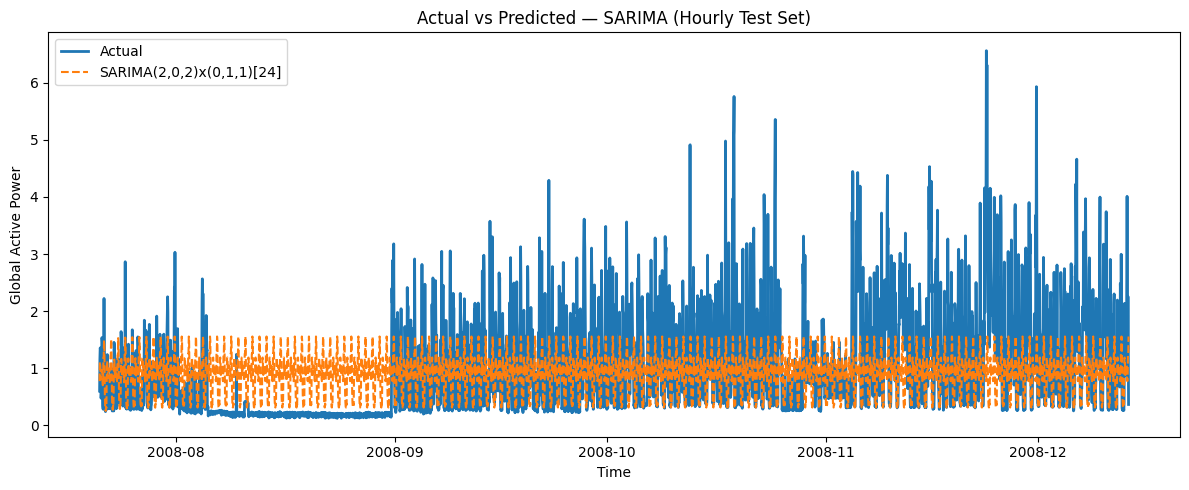

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test, label="Actual", linewidth=2)
plt.plot(sarima_best_pred,
         label=f"SARIMA({best_p},{best_d},{best_q})x({best_P},{best_D},{best_Q})[{m}]",
         linestyle="--")

plt.title("Actual vs Predicted — SARIMA (Hourly Test Set)")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
sarima_results_table = pd.DataFrame({
    "Actual": test,
    f"SARIMA({best_p},{best_d},{best_q})x({best_P},{best_D},{best_Q})[{m}]_Prediction":
        sarima_best_pred
})

sarima_results_table.head()

,Actual,"SARIMA(2,0,2)x(0,1,1)[24]_Prediction"
timestamp,,
2008-07-21 06:00:00,0.601167,0.774955
2008-07-21 07:00:00,1.161033,1.111409
2008-07-21 08:00:00,1.356633,1.112729
2008-07-21 09:00:00,1.332733,0.931696
2008-07-21 10:00:00,0.669400,0.805546
